In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator_psc import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption, regplot, scatterplot
import copy
from IPython.display import display
from collections import defaultdict
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import pathlib
from multiprocessing import  Pool

In [3]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

In [4]:
# p = pathlib.Path('../cluster/results/')
# path = pathlib.Path('../longrun_new/')
# path = pathlib.Path('../cluster/long_run_4000/')
# path = pathlib.Path('../results/')
path = pathlib.Path('/media/storage/causal_opto_data/results_400k/')

In [5]:
import json
with open(str(path / 'params.json'), 'r') as f:
    params = json.load(f)

t_stop = params['status']['time']

In [6]:
conn = pd.read_feather('../params_1_psc_connections.feather')

In [7]:
sender_ids = conn.query('weight >= 0').source.sort_values().unique()

In [8]:
stim_data = np.load(path / 'stimulation_data_0.npz', allow_pickle=True)['data'][()]
stim_times = np.array(stim_data['times'])
stim_durations = np.array(stim_data['durations'])

In [9]:
conn.loc[:,'source_stimulated'] = conn.source.isin(stim_data['stim_nodes']['ex'])
conn.loc[:,'target_stimulated'] = conn.target.isin(stim_data['stim_nodes']['ex'])
conn['stim_amp_source'] = conn.progress_apply(
    lambda x: stim_data['stim_amps']['ex'].get(x.source, 0), axis=1)

HBox(children=(IntProgress(value=0, max=1600000), HTML(value='')))

In [10]:
X = np.load(path / 'X.npy')
Y = np.load(path / 'Y.npy')
Z = np.load(path / 'Z.npy')

# look at all

In [22]:
N = 200
# query = 'stim_amp_source > 600 and stim_amp_source < 800 and weight > 0 and not target_stimulated and target_ex'
query = 'weight > 0 and not target_stimulated and target in @sender_ids'
sample = conn.query(query)


In [23]:
sample.sort_values('weight', ascending=False).head()

,weight,source,target,source_stimulated,target_stimulated,stim_amp_source
854645,1.999977,2138,2951,False,False,0.000000
1011297,1.999802,2530,1359,False,False,0.000000
494431,1.999735,1238,2670,False,False,0.000000
175600,1.999691,440,1854,True,False,3.738992
495142,1.999687,1240,1297,False,False,0.000000


In [24]:
sample['wr'] = sample.weight.round(3)
sample = sample.drop_duplicates('wr')

# sample = sample.sample(2000)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
sample.target.max(), sample.target.min()

(3200, 996)

In [26]:
def process(row):
    z = Z[:,int(row.source) - 1]
    x = X[:,int(row.source) - 1]
    y = Y[:,int(row.target) - 1]
    y_ref = y[z==1]
    y_respons = y[x==1].mean()
    beta_iv = y_respons - y_ref.mean()
#     wald = (y[z==1].mean() - y[z==0].mean()) / (x[z==1].mean() - x[z==0].mean())
#     beta = y_respons - y[x==0].mean()
    beta = y_respons - np.random.choice(y[x==0], len(y_ref)).mean()
#     print(
#         len(y[z==1]), y[z==1].mean(), 
#         len(np.random.choice(y[x==0], int(sum(z)))), np.random.choice(y[x==0], int(sum(z))).mean())
#     return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean(), 'wald': wald})
    return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean()})

In [27]:
process(sample.iloc[0,:])

beta        0.210975
beta_iv     0.168488
hit_rate    0.891203
dtype: float64

In [28]:
def parall_apply(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def apply(x): 
    return x.apply(process, axis=1, result_type="expand")

In [44]:
np.where(Z==1, X, X*0).sum(0)

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
Z.max(), X.max(), Y.max()

(1.0, 1.0, 1.0)

In [29]:
# result = sample.join(sample.progress_apply(process, axis=1, result_type="expand"))
result = sample.join(parall_apply(sample, apply))

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

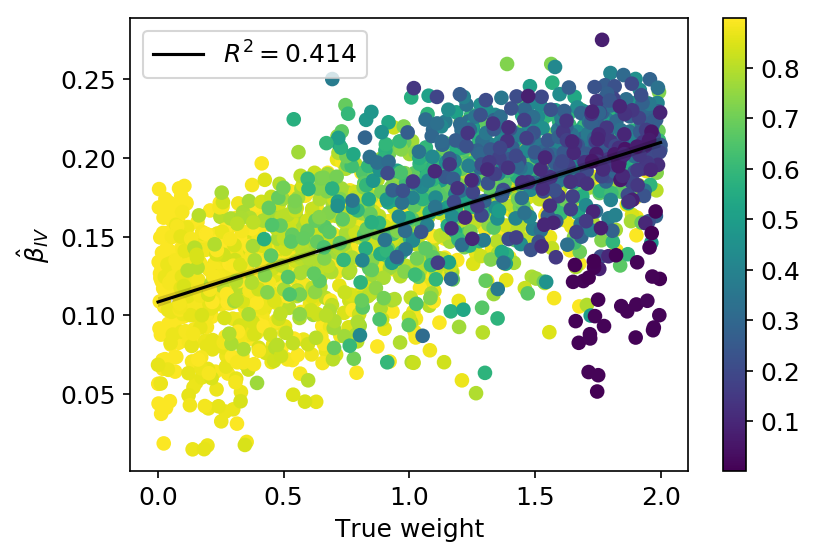

In [45]:
df_ = result#.query('hit_rate > 0.2 and hit_rate < .8')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

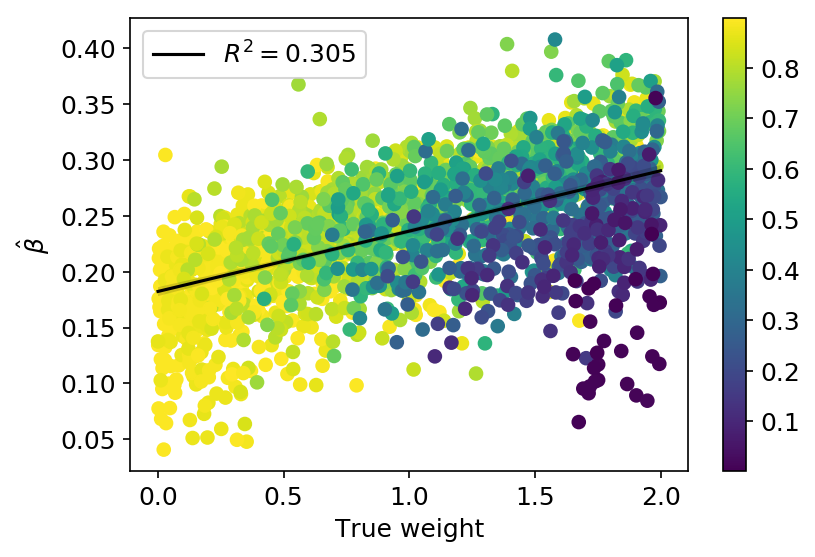

In [46]:
df_ = result#.query('hit_rate > .1 and hit_rate < .8')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'$\\hat{\\beta}$')

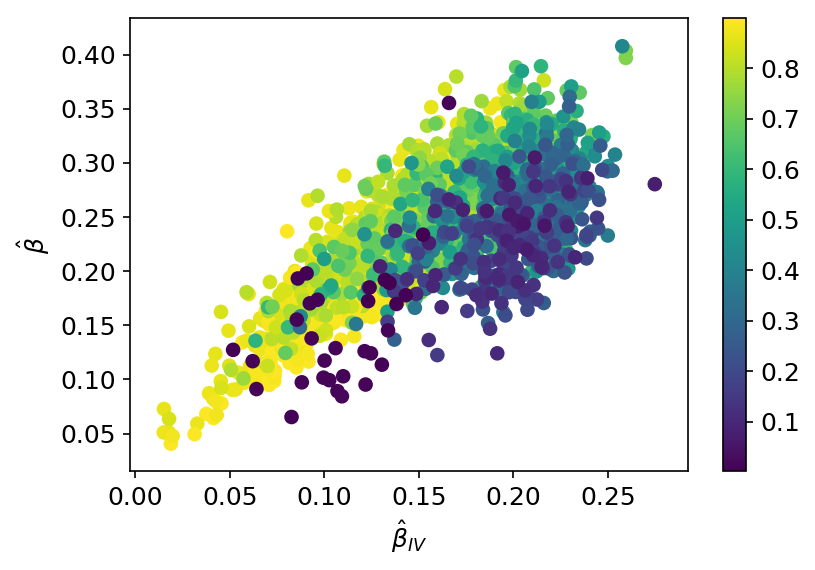

In [32]:
scatterplot(
    'beta_iv', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'True weight')

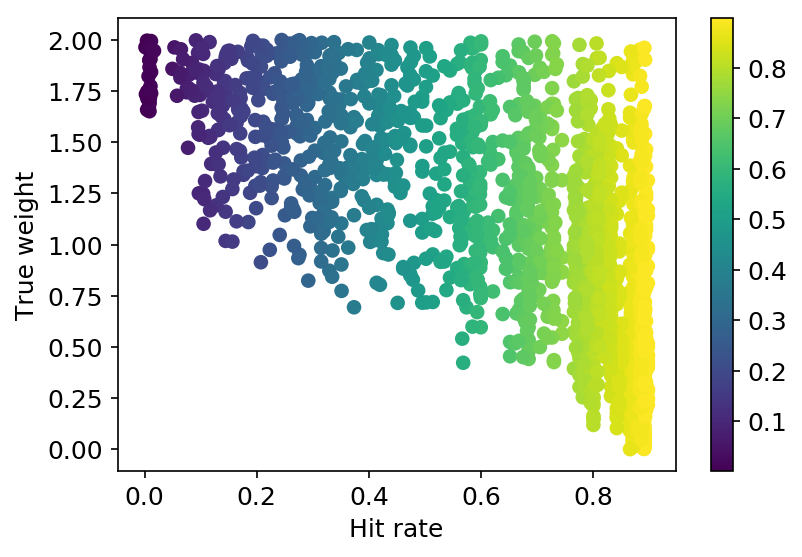

In [33]:
scatterplot(
    'hit_rate', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Hit rate')
plt.ylabel('True weight')

In [1]:
scatterplot(
    'source', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Source')
plt.ylabel('True weight')

NameError: name 'scatterplot' is not defined

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

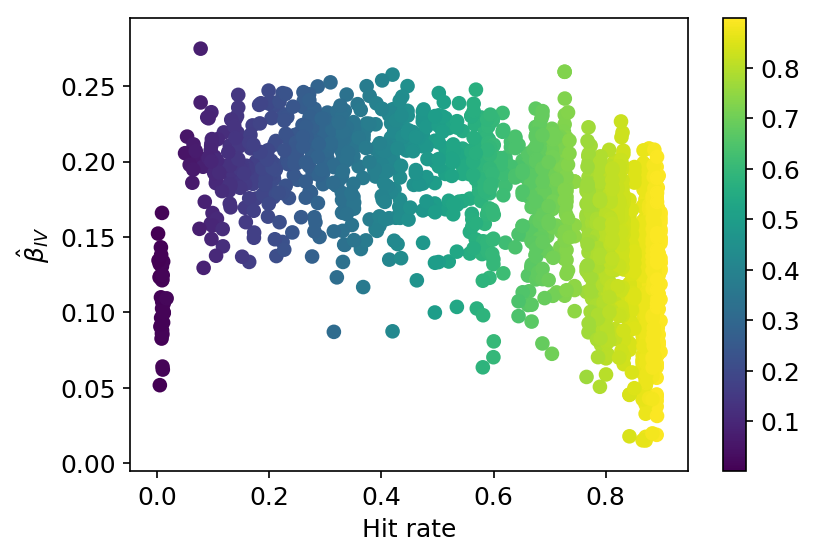

In [34]:
scatterplot(
    'hit_rate', 'beta_iv', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

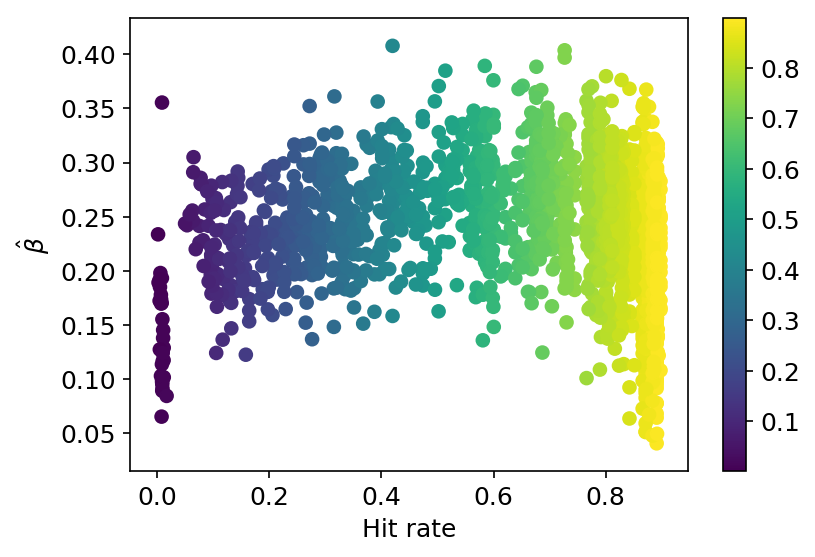

In [35]:
scatterplot(
    'hit_rate', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

Text(0.5,0,'source')

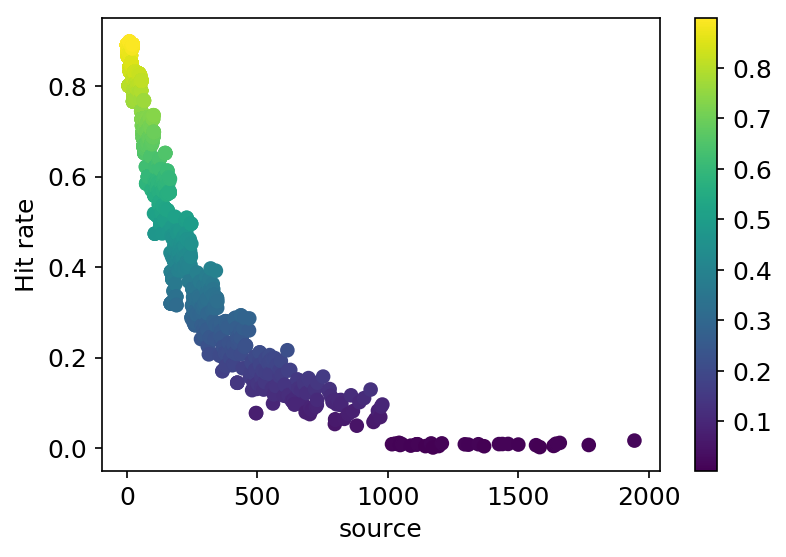

In [36]:
model = scatterplot(
    'source', 'hit_rate', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.ylabel(r'Hit rate')
plt.xlabel(r'source')

# zero weight

In [38]:
N = 200
query = 'weight < 0.001 and weight >= 0 and not target_stimulated and target in @sender_ids'
sample_zero = conn.query(query)

In [39]:
sample_zero = sample_zero.sample(2000)

In [40]:
result_zero = sample_zero.join(parall_apply(sample_zero, apply))

([<matplotlib.axis.XTick at 0x7f4be8010a20>,
 <a list of 2 Text xticklabel objects>)

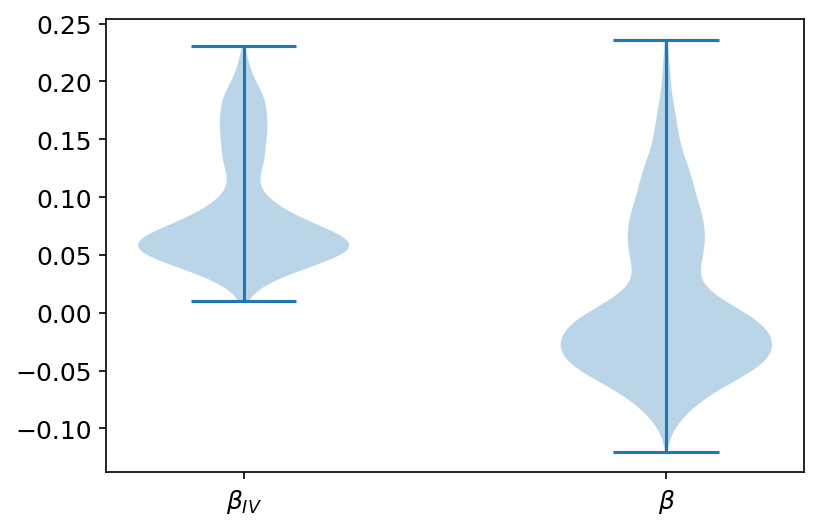

In [41]:
plt.violinplot(result_zero.loc[:, ['beta_iv', 'beta']].T)
plt.xticks([1, 2], [r'$\beta_{IV}$', r'$\beta$'])